In [1]:
import os 
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
reverb_log_dir = '../Logs/circular_array_7mic/reverb/'
noisy_log_dir = '../Logs/circular_array_7mic/noisy/point_source'
noisy_reverb_ps_log_dir = '../Logs/circular_array_7mic/noisy_reverb/point_source'
noisy_reverb_diffuse_log_dir = '../Logs/circular_array_7mic/noisy_reverb/diffuse'

In [4]:
Loss = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
num_mics_list = [7]
doa_measures = ["frm_Acc_epoch", "utt_Acc_epoch", 'mae_only_correct', 'mae_only_incorrect', 'mae_overall']
se_measures = ["STOI", "PESQ_NB", "SNR"]

In [4]:
search_doa_pattern_list = []
for loss in Loss:
    for measure in doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        search_doa_pattern_list.append(doa_info_pattern)

search_doa_pattern_list.append("mix_7mic_frm_Acc_epoch")          

In [5]:
search_se_pattern_list = []
for loss in Loss:
    for measure in se_measures:
        se_info_pattern = f'{measure}_{loss}' #inside file pattern
        search_se_pattern_list.append(se_info_pattern)

search_se_pattern_list.append("MIX_STOI_epoch")
search_se_pattern_list.append("MIX_PESQ_NB_epoch")    

In [6]:
def search_metrics_pattern_file(file_path, search_pattern_list):
    exp_dict = {}
    app_str = ""
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if app_str=="":
                snr, t60, app_str = get_test_config_details(line)
                
            for search_pattern in search_pattern_list: #search_doa_pattern_list:
                if search_pattern in line:
                    line_split_info = line.split()
                    #print(line_split_info, len(line_split_info))
                    if len(line_split_info)==5:
                        key_str = f'{line_split_info[1]}_{app_str}'

                        exp_dict[key_str] = float(line_split_info[3])
                        #print(key_str, line.split()[3])
                
    return exp_dict

In [7]:
def get_all_exp_metrics_dict(log_dir: str, search_pattern: list):
    log_dir_files = os.listdir(log_dir)
    _exp_dict={}
    for _file in log_dir_files:
        file_path = os.path.join(log_dir, _file)
        exp_dict = search_metrics_pattern_file(file_path, search_pattern)
        _exp_dict.update(exp_dict)
    
    return _exp_dict

In [25]:
reverb_exp_dict = get_all_exp_dict(reverb_log_dir, search_se_pattern_list)
noisy_exp_dict = get_all_exp_metrics_dict(noisy_log_dir, search_se_pattern_list)
noisy_reverb_ps_exp_dict = get_all_exp_metrics_dict(noisy_reverb_ps_log_dir, search_se_pattern_list)
noisy_reverb_diffuse_exp_dict = get_all_exp_metrics_dict(noisy_reverb_diffuse_log_dir, search_se_pattern_list)

In [26]:
reverb_exp_dict

{'MIX_PESQ_NB_epoch_t60_0.0': 4.499999993571571,
 'MIX_STOI_epoch_t60_0.0': 0.9999999985714629,
 'MIX_PESQ_NB_epoch_t60_0.2': 3.032204778865076,
 'MIX_STOI_epoch_t60_0.2': 0.923069768091024,
 'MIX_PESQ_NB_epoch_t60_0.3': 2.507631806425527,
 'MIX_STOI_epoch_t60_0.3': 0.8591675106803282,
 'MIX_PESQ_NB_epoch_t60_0.4': 2.242078691215476,
 'MIX_STOI_epoch_t60_0.4': 0.8064831796461915,
 'MIX_PESQ_NB_epoch_t60_0.5': 2.073328084386175,
 'MIX_STOI_epoch_t60_0.5': 0.7619537561797988,
 'MIX_PESQ_NB_epoch_t60_0.6': 1.9518717485205728,
 'MIX_STOI_epoch_t60_0.6': 0.7238904317213066,
 'MIX_PESQ_NB_epoch_t60_0.7': 1.8591733693776753,
 'MIX_STOI_epoch_t60_0.7': 0.6910809393517838,
 'MIX_PESQ_NB_epoch_t60_0.8': 1.7853757829358503,
 'MIX_STOI_epoch_t60_0.8': 0.6626190416237828,
 'MIX_PESQ_NB_epoch_t60_0.9': 1.7243945589405463,
 'MIX_STOI_epoch_t60_0.9': 0.6377706746543521,
 'MIX_PESQ_NB_epoch_t60_1.0': 1.6733905131334552,
 'MIX_STOI_epoch_t60_1.0': 0.6159532881566145}

Generated numbers for paper using below snippet

In [28]:
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
measures_list = ["STOI", "PESQ_NB"]
keys_list = reverb_exp_dict.keys()
for loss in Loss:
    for measure in measures_list:
        val_list=[]
        for t60 in t60_list: 
            app_str = f"t60_{t60}"  
            key_str = f'{loss}_{measure}_{app_str}' #f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
            if key_str in keys_list:
                val = reverb_exp_dict[key_str]
            else:
                val = 0.0
            val_list.append(val)
        print(f"{loss}, {measure}, {np.mean(val_list)}")

#Mixtures numbers
for measure in measures_list:
    val_list=[]
    for t60 in t60_list: 
        app_str = f"t60_{t60}"  
        key_str = f'MIX_{measure}_epoch_{app_str}' #f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
        if key_str in keys_list:
            val = reverb_exp_dict[key_str]
        else:
            val = 0.0
        val_list.append(val)
    print(f"{loss}, {measure}, {np.mean(val_list)}")

MIX, STOI, 0.0
MIX, PESQ_NB, 0.0
MIX, STOI, 0.7681988588676646
MIX, PESQ_NB, 2.3349449327371925


In [20]:
exp_dict = noisy_reverb_diffuse_exp_dict # noisy_reverb_diffuse_exp_dict

snr_list = [-5.0, 0.0, 5.0]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
measures_list = ["STOI", "PESQ_NB"]
keys_list = exp_dict.keys()
num_mics = 7

for _snr in snr_list:
    for loss in Loss:
        for measure in measures_list:
            val_list=[] 
            for t60 in t60_list:                                                   
                for mic_idx in range(num_mics):                 
                    app_str = f"snr_{_snr}_t60_{t60}"  
                    key_str = f'{measure}_{loss}_{mic_idx}_epoch_{app_str}' #f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

                    if key_str in keys_list:
                        val = exp_dict[key_str]
                    else:
                        #print(key_str)
                        val = 0.0
                    val_list.append(val)
            print(f"{num_mics}, {_snr}, {loss}, {measure}, {np.mean(val_list)}")


#Mixtures numbers
for measure in measures_list:
    val_list=[] 
    for _snr in snr_list:    
        for t60 in t60_list:                                                                        
            app_str = f"snr_{_snr}_t60_{t60}"  
            key_str = f'MIX_{measure}_epoch_{app_str}' #f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

            if key_str in keys_list:
                val = exp_dict[key_str]
            else:
                #print(key_str)
                val = 0.0
            val_list.append(val)
            #print(val_list)
    print(f"MIX, {measure}, {np.mean(val_list)}")

7, -5.0, MIMO_RI, STOI, 0.7234061941193257
7, -5.0, MIMO_RI, PESQ_NB, 1.5324384416852679
7, -5.0, MIMO_RI_MAG, STOI, 0.7375933048716095
7, -5.0, MIMO_RI_MAG, PESQ_NB, 1.8426005227225168
7, -5.0, MIMO_RI_MAG_PD, STOI, 0.7546233716500473
7, -5.0, MIMO_RI_MAG_PD, PESQ_NB, 1.8117943048477172
7, -5.0, MIMO_RI_PD, STOI, 0.7325771922915483
7, -5.0, MIMO_RI_PD, PESQ_NB, 1.3733844893319267
7, -5.0, MIMO_RI_PD_REF, STOI, 0.6974928004504272
7, -5.0, MIMO_RI_PD_REF, PESQ_NB, 1.1503851413726807
7, 0.0, MIMO_RI, STOI, 0.8254334154416755
7, 0.0, MIMO_RI, PESQ_NB, 1.938791847229004
7, 0.0, MIMO_RI_MAG, STOI, 0.8344879874772836
7, 0.0, MIMO_RI_MAG, PESQ_NB, 2.2768325192587717
7, 0.0, MIMO_RI_MAG_PD, STOI, 0.8481365079979222
7, 0.0, MIMO_RI_MAG_PD, PESQ_NB, 2.2420699664524624
7, 0.0, MIMO_RI_PD, STOI, 0.8343238803025675
7, 0.0, MIMO_RI_PD, PESQ_NB, 1.8383290427071708
7, 0.0, MIMO_RI_PD_REF, STOI, 0.8070678064265274
7, 0.0, MIMO_RI_PD_REF, PESQ_NB, 1.5920016731534685
7, 5.0, MIMO_RI, STOI, 0.879038751449

In [18]:
noisy_reverb_ps_exp_dict

{'ESTOI_MIMO_RI_0_epoch_snr_-5.0_t60_0.4': 0.5298844819302346,
 'ESTOI_MIMO_RI_1_epoch_snr_-5.0_t60_0.4': 0.5271225804073133,
 'ESTOI_MIMO_RI_2_epoch_snr_-5.0_t60_0.4': 0.5256704091249019,
 'ESTOI_MIMO_RI_3_epoch_snr_-5.0_t60_0.4': 0.5259849056457784,
 'ESTOI_MIMO_RI_4_epoch_snr_-5.0_t60_0.4': 0.5271794432637383,
 'ESTOI_MIMO_RI_5_epoch_snr_-5.0_t60_0.4': 0.5257418455759776,
 'ESTOI_MIMO_RI_6_epoch_snr_-5.0_t60_0.4': 0.5264378343622655,
 'ESTOI_MIMO_RI_MAG_0_epoch_snr_-5.0_t60_0.4': 0.535503476674313,
 'ESTOI_MIMO_RI_MAG_1_epoch_snr_-5.0_t60_0.4': 0.5298761615315349,
 'ESTOI_MIMO_RI_MAG_2_epoch_snr_-5.0_t60_0.4': 0.5285932544484139,
 'ESTOI_MIMO_RI_MAG_3_epoch_snr_-5.0_t60_0.4': 0.5288080718726439,
 'ESTOI_MIMO_RI_MAG_4_epoch_snr_-5.0_t60_0.4': 0.5298031074520588,
 'ESTOI_MIMO_RI_MAG_5_epoch_snr_-5.0_t60_0.4': 0.5286674458009756,
 'ESTOI_MIMO_RI_MAG_6_epoch_snr_-5.0_t60_0.4': 0.5289827368169502,
 'ESTOI_MIMO_RI_MAG_PD_0_epoch_snr_-5.0_t60_0.4': 0.538090090173554,
 'ESTOI_MIMO_RI_MAG_PD

In [15]:
exp_dict = noisy_exp_dict # noisy_reverb_diffuse_exp_dict
Loss = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
measures_list = ["STOI", "PESQ_NB"]
keys_list = exp_dict.keys()
num_mics = 7

for _snr in snr_list:
    for loss in Loss:
        for measure in measures_list:
            val_list=[] 
                                                              
            for mic_idx in range(num_mics):                 
                app_str = f"snr_{_snr}"  
                key_str = f'{measure}_{loss}_{mic_idx}_epoch_{app_str}' #f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

                if key_str in keys_list:
                    val = exp_dict[key_str]
                else:
                    #print(key_str)
                    val = 0.0
                val_list.append(val)
            #print(val_list)
            print(f"{num_mics}, {_snr}, {loss}, {measure}, {np.mean(val_list)}")


#Mixtures numbers
for measure in measures_list:
    val_list=[] 
    for _snr in snr_list:                                                                            
        app_str = f"snr_{_snr}"  
        key_str = f'MIX_{measure}_epoch_{app_str}' #f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

        if key_str in keys_list:
            val = exp_dict[key_str]
        else:
            #print(key_str)
            val = 0.0
        val_list.append(val)
        #print(val_list)
    print(f"MIX, {measure}, {np.mean(val_list)}")

7, -5.0, MIMO_RI, STOI, 0.8661837617316259
7, -5.0, MIMO_RI, PESQ_NB, 2.2993836062295094
7, -5.0, MIMO_RI_MAG, STOI, 0.8727346103972194
7, -5.0, MIMO_RI_MAG, PESQ_NB, 2.5621629783085416
7, -5.0, MIMO_RI_MAG_PD, STOI, 0.9038450992679804
7, -5.0, MIMO_RI_MAG_PD, PESQ_NB, 2.7668185574667796
7, -5.0, MIMO_RI_PD, STOI, 0.974255138534101
7, -5.0, MIMO_RI_PD, PESQ_NB, 3.4477354117802212
7, -5.0, MIMO_RI_PD_REF, STOI, 0.9489245881169206
7, -5.0, MIMO_RI_PD_REF, PESQ_NB, 3.073134115764073
7, -2.5, MIMO_RI, STOI, 0.8967155126101511
7, -2.5, MIMO_RI, PESQ_NB, 2.5241102491106306
7, -2.5, MIMO_RI_MAG, STOI, 0.9010102942941437
7, -2.5, MIMO_RI_MAG, PESQ_NB, 2.772176742553711
7, -2.5, MIMO_RI_MAG_PD, STOI, 0.9262568005802472
7, -2.5, MIMO_RI_MAG_PD, PESQ_NB, 2.977482761655535
7, -2.5, MIMO_RI_PD, STOI, 0.9812623440633688
7, -2.5, MIMO_RI_PD, PESQ_NB, 3.6085314410073415
7, -2.5, MIMO_RI_PD_REF, STOI, 0.9615460825618646
7, -2.5, MIMO_RI_PD_REF, PESQ_NB, 3.2584164483206615
7, 0.0, MIMO_RI, STOI, 0.92037

In [12]:
noisy_exp_dict

{'ESTOI_MIMO_RI_0_epoch_snr_-5.0': 0.732861206637787,
 'ESTOI_MIMO_RI_1_epoch_snr_-5.0': 0.7324566259520224,
 'ESTOI_MIMO_RI_2_epoch_snr_-5.0': 0.731390669301194,
 'ESTOI_MIMO_RI_3_epoch_snr_-5.0': 0.7311991550957844,
 'ESTOI_MIMO_RI_4_epoch_snr_-5.0': 0.732765382145308,
 'ESTOI_MIMO_RI_5_epoch_snr_-5.0': 0.7329384457098113,
 'ESTOI_MIMO_RI_6_epoch_snr_-5.0': 0.7331586542351205,
 'ESTOI_MIMO_RI_MAG_0_epoch_snr_-5.0': 0.74272510044429,
 'ESTOI_MIMO_RI_MAG_1_epoch_snr_-5.0': 0.740840867763742,
 'ESTOI_MIMO_RI_MAG_2_epoch_snr_-5.0': 0.7396165337728678,
 'ESTOI_MIMO_RI_MAG_3_epoch_snr_-5.0': 0.7405669073386509,
 'ESTOI_MIMO_RI_MAG_4_epoch_snr_-5.0': 0.7411898411534761,
 'ESTOI_MIMO_RI_MAG_5_epoch_snr_-5.0': 0.7401359535230126,
 'ESTOI_MIMO_RI_MAG_6_epoch_snr_-5.0': 0.7398803006142973,
 'ESTOI_MIMO_RI_MAG_PD_0_epoch_snr_-5.0': 0.7877894163367672,
 'ESTOI_MIMO_RI_MAG_PD_1_epoch_snr_-5.0': 0.7910833579620103,
 'ESTOI_MIMO_RI_MAG_PD_2_epoch_snr_-5.0': 0.7914554741327735,
 'ESTOI_MIMO_RI_MAG_PD

In [35]:
noisy_reverb_diffuse_exp_dict

{'ESTOI_MIMO_RI_0_epoch_snr_-5.0_t60_0.4': 0.5740826569325922,
 'ESTOI_MIMO_RI_1_epoch_snr_-5.0_t60_0.4': 0.5693433320507422,
 'ESTOI_MIMO_RI_2_epoch_snr_-5.0_t60_0.4': 0.569528112990021,
 'ESTOI_MIMO_RI_3_epoch_snr_-5.0_t60_0.4': 0.5691783280432705,
 'ESTOI_MIMO_RI_4_epoch_snr_-5.0_t60_0.4': 0.5685257731770128,
 'ESTOI_MIMO_RI_5_epoch_snr_-5.0_t60_0.4': 0.5697114976342594,
 'ESTOI_MIMO_RI_6_epoch_snr_-5.0_t60_0.4': 0.5691017873152486,
 'ESTOI_MIMO_RI_MAG_0_epoch_snr_-5.0_t60_0.4': 0.5806822537369191,
 'ESTOI_MIMO_RI_MAG_1_epoch_snr_-5.0_t60_0.4': 0.5771464181608938,
 'ESTOI_MIMO_RI_MAG_2_epoch_snr_-5.0_t60_0.4': 0.5766229233168496,
 'ESTOI_MIMO_RI_MAG_3_epoch_snr_-5.0_t60_0.4': 0.5760031064303373,
 'ESTOI_MIMO_RI_MAG_4_epoch_snr_-5.0_t60_0.4': 0.5765606319812319,
 'ESTOI_MIMO_RI_MAG_5_epoch_snr_-5.0_t60_0.4': 0.5757520689186867,
 'ESTOI_MIMO_RI_MAG_6_epoch_snr_-5.0_t60_0.4': 0.5766171184726651,
 'ESTOI_MIMO_RI_MAG_PD_0_epoch_snr_-5.0_t60_0.4': 0.6060635892915126,
 'ESTOI_MIMO_RI_MAG_P

In [5]:
reverb_doa_measures = ["est_frm_Acc_epoch", "est_utt_Acc_epoch", 'est_mae_only_corr', 'est_mae_only_incorr', 'est_mae_overall']
reverb_search_doa_pattern_list = []
for loss in Loss:
    for measure in reverb_doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        reverb_search_doa_pattern_list.append(doa_info_pattern)

reverb_search_doa_pattern_list.append("mix_frm_Acc_epoch") 

In [9]:
def get_test_config_details(line):
    snr,t60,app_str = None, None,""
    
    if "dataset_condition:" in line:
        line_split_info = line.split(',')
        if line_split_info[-1]=='':
            line_split_info.pop()
        dataset_condition = line_split_info[-1].split()[-1]
        if dataset_condition=="noisy":
            snr = line_split_info[-3].split()[-1]
            app_str = f'snr_{snr}'
        elif dataset_condition=="noisy_reverb":
            
            snr = line_split_info[-3].split()[-1]
            t60 = line_split_info[-4].split()[-1]
            app_str = f'snr_{snr}_t60_{t60}'
            
        elif dataset_condition=="reverb":
            t60 = line_split_info[-4].split()[-1]
            app_str = f't60_{t60}'

            
    return snr, t60, app_str

In [24]:
#search_pattern_file
def search_pattern_file(file_path, search_pattern_list):
    exp_dict = {}
    app_str = ""
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if app_str=="":
                snr, t60, app_str = get_test_config_details(line)
                
            for search_pattern in search_pattern_list: #search_doa_pattern_list:
                if search_pattern in line:
                    line_split_info = line.split()
                    #print(line_split_info, len(line_split_info))
                    if len(line_split_info)==5:
                        key_str = f'{search_pattern}_{app_str}'
                        exp_dict[key_str] = float(line_split_info[3])
                        #print(key_str, line.split()[3])
                
    return exp_dict
        


In [22]:
def get_all_exp_dict(log_dir: str, search_pattern: list):
    log_dir_files = os.listdir(log_dir)
    _exp_dict={}
    for _file in log_dir_files:
        file_path = os.path.join(log_dir, _file)
        exp_dict = search_pattern_file(file_path, search_pattern)
        _exp_dict.update(exp_dict)
    
    return _exp_dict

In [9]:
reverb_exp_dict = get_all_exp_dict(reverb_log_dir, reverb_search_doa_pattern_list)
noisy_exp_dict = get_all_exp_dict(noisy_log_dir, search_doa_pattern_list)
noisy_reverb_ps_exp_dict = get_all_exp_dict(noisy_reverb_ps_log_dir, search_doa_pattern_list)
noisy_reverb_diffuse_exp_dict = get_all_exp_dict(noisy_reverb_diffuse_log_dir, search_doa_pattern_list)

In [9]:
#plotting frm Acc
from itertools import product

noisy_snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]

noisy_reverb_snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0 ]
noisy_reverb_t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
noisy_reverb_list = list(product(noisy_reverb_snr_list, noisy_reverb_t60_list))

reverb_t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [16]:
def build_app_str(dataset_condition, val):
    if dataset_condition=="noisy":
        app_str = f'snr_{val}'
    elif dataset_condition=="noisy_reverb":
        app_str = f'snr_{val[0]}_t60_{val[1]}'   
    elif dataset_condition=="reverb":
        app_str = f't60_{val}'
    return app_str

In [12]:
def _plot(measure, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    plt.figure()
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            key_str = f'{loss}_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        #print(loss, val_list)
        if dataset_condition != "noisy_reverb":
            plt.plot(tst_conditions, val_list) 
        else:
            plt.plot(val_list) 
    plt.legend(loss_list)
    plt.title(f'{dataset_condition}_{dataset_simulation}')
        
        


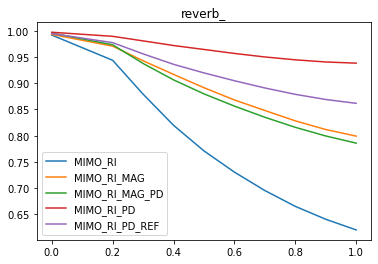

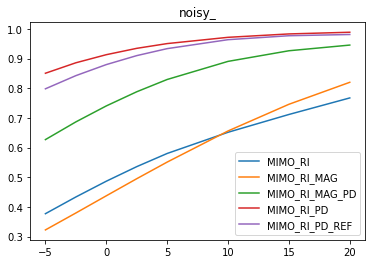

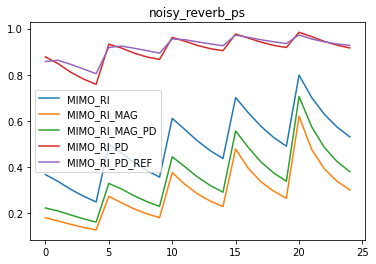

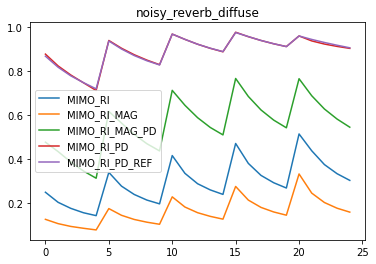

In [13]:
_plot("est_frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_plot("frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

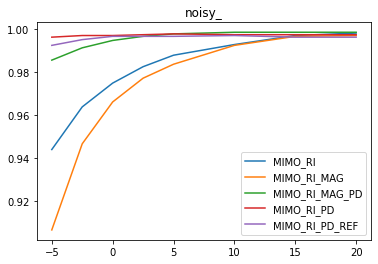

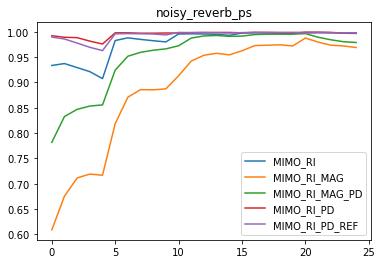

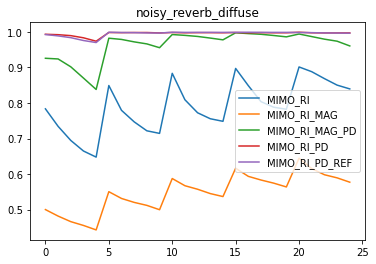

In [14]:
_plot("utt_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("utt_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("utt_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

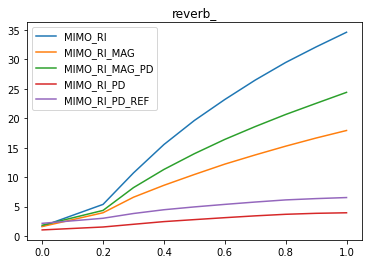

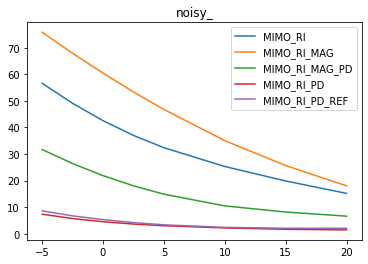

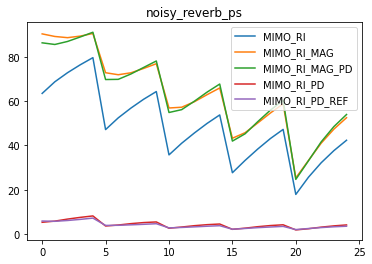

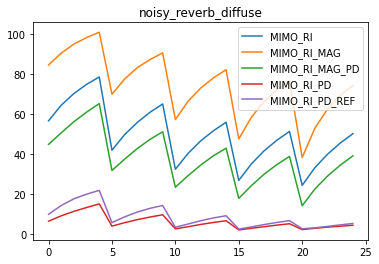

In [15]:
_plot("est_mae_overall", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_plot("mae_overall", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("mae_overall", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("mae_overall", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

In [7]:
#debugging 
#circular array analysis
log_dir = '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_circular_array/noisy_reverb/diffuse/t60_1.0_snr_-5.0dB_corrected_doa_sig_norm'
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
idx = 0
all_est_dict = torch.load(os.path.join(log_dir, f'doa_1.0_{idx}_tol_5.0deg_euclid_True_wgt_mech_MASK.pt'))
for loss in loss_list:
    (est_f_doa, est_f_vals, est_utt_doa, est_frm_Acc, est_utt_Acc, metrics_list, est_mae_only_correct_frms, est_mae_only_incorrect_frms, est_mae_overall_only_vad_frms) = all_est_dict[f'{loss}']
    plt.figure()
    plt.title(f'{loss}')
    plt.plot(est_f_doa)
    plt.plot(est_utt_doa*torch.ones(len(est_f_doa)))
    plt.plot(360 - est_utt_doa*torch.ones(len(est_f_doa)))
    #plt.plot(360 - (est_utt_doa-90)*torch.ones(len(est_f_doa)))



FileNotFoundError: [Errno 2] No such file or directory: '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_circular_array/noisy_reverb/diffuse/t60_0.8_snr_-5.0dB_corrected_doa_sig_norm/doa_1.0_3_tol_5.0deg_euclid_True_wgt_mech_MASK.pt'

In [3]:
est_utt_doa

327

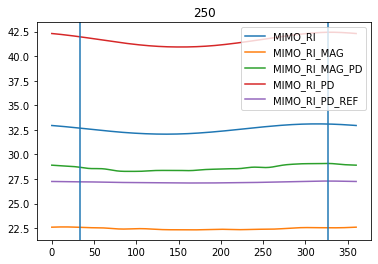

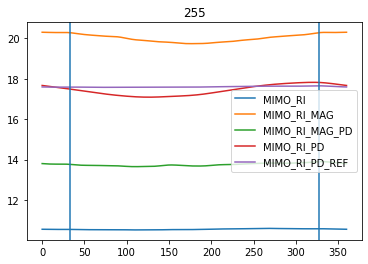

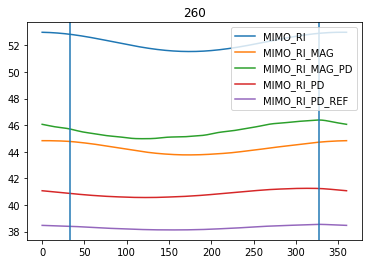

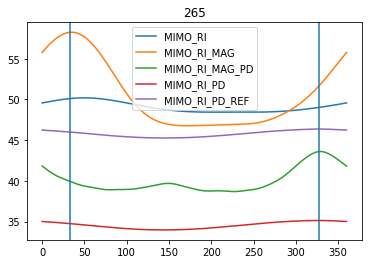

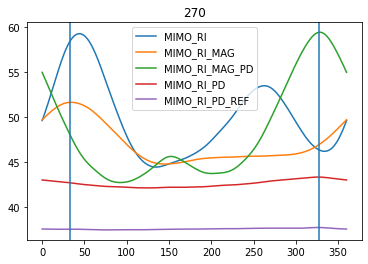

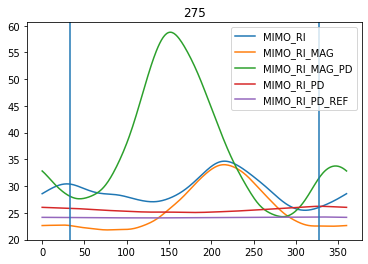

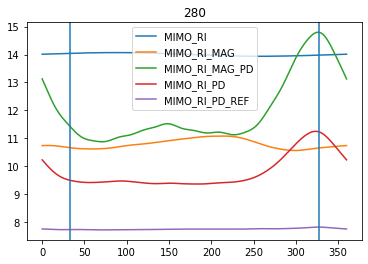

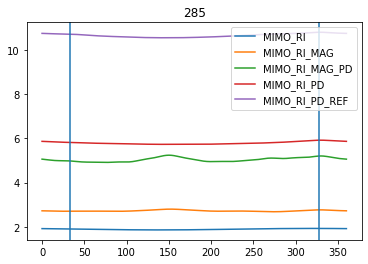

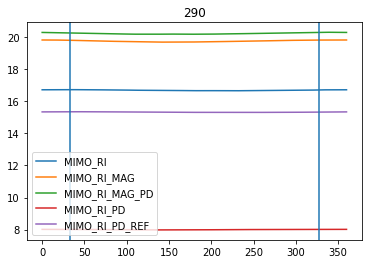

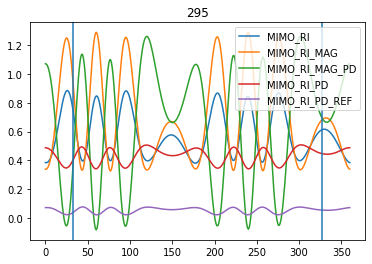

In [6]:
#circular array analysis
log_dir = '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_circular_array/noisy_reverb/diffuse/t60_1.0_snr_-5.0dB_corrected_doa_sig_norm'
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
idx = 3
all_est_dict = torch.load(os.path.join(log_dir, f'doa_1.0_{idx}_tol_5.0deg_euclid_True_wgt_mech_MASK.pt'))
for frm in range(250, 300, 5):
    plt.figure()
    for loss in loss_list:
        (est_f_doa, est_f_vals, est_utt_doa, est_frm_Acc, est_utt_Acc, metrics_list, est_mae_only_correct_frms, est_mae_only_incorrect_frms, est_mae_overall_only_vad_frms) = all_est_dict[f'{loss}']
        #plt.figure()
        plt.title(f'{frm}')
        plt.plot(est_f_vals.flatten('F')[361*(frm-1):361*frm]) #column (theta)
    plt.axvline(x=est_utt_doa)
    plt.axvline(x=360-est_utt_doa)
    
    #plt.plot(est_utt_doa*torch.ones(361))
    #plt.plot(360 - est_utt_doa*torch.ones(361))
    plt.legend(loss_list)

In [18]:
est_utt_doa

132

In [19]:
#Linear real rirs
real_doa_measures = ["est_8mic_enh_frm_Acc"]
real_noisy_reverb_ps_log_dir = '../Logs/8cm_array_8mic/noisy_reverb/point_source_real_rirs'
real_reverb_log_dir = '../Logs/8cm_array_8mic/reverb/real_rirs'

real_search_doa_pattern_list = []
for loss in Loss:
    for measure in real_doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        real_search_doa_pattern_list.append(doa_info_pattern)

real_search_doa_pattern_list.append('mix_8mic_frm_Acc_epoch')

In [20]:
real_noisy_reverb_ps_exp_dict = get_all_exp_dict(real_noisy_reverb_ps_log_dir, real_search_doa_pattern_list)
real_reverb_exp_dict = get_all_exp_dict(real_reverb_log_dir, real_search_doa_pattern_list)

In [21]:
real_noisy_reverb_ps_exp_dict

{'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.4912605881690979,
 'MIMO_RI_MAG_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.6924976706504822,
 'MIMO_RI_PD_REF_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.8823594450950623,
 'MIMO_RI_PD_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.9609727263450623,
 'MIMO_RI_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.8815603256225586,
 'mix_8mic_frm_Acc_epoch_snr_0.0_t60_0.36': 0.14791962504386902,
 'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.31176233291625977,
 'MIMO_RI_MAG_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.5178917646408081,
 'MIMO_RI_PD_REF_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.7432851195335388,
 'MIMO_RI_PD_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.8885875940322876,
 'MIMO_RI_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.7783611416816711,
 'mix_8mic_frm_Acc_epoch_snr_-5.0_t60_0.36': 0.07069886475801468,
 'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_0.0_t60_0.61': 0.47190234065055847,
 'MIMO_RI_MAG_est_8mic_enh_frm_Acc_snr_0.0_

In [22]:
real_noisy_reverb_snr_list = [-5.0, 0.0, 5.0]
real_noisy_reverb_t60_list = [0.16, 0.36, 0.61]
real_noisy_reverb_list = list(product(real_noisy_reverb_snr_list, real_noisy_reverb_t60_list))

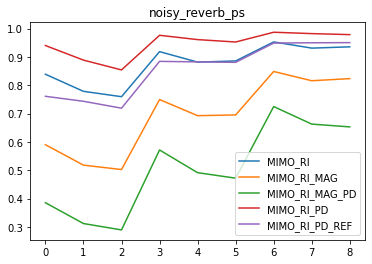

In [23]:
_plot("est_8mic_enh_frm_Acc", real_noisy_reverb_ps_exp_dict, "noisy_reverb", real_noisy_reverb_list, Loss, "ps")

In [24]:
def _print(measure, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    print(tst_conditions)
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            key_str = f'{loss}_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        print(loss, val_list)

        
        


In [25]:
_print("est_8mic_enh_frm_Acc", real_noisy_reverb_ps_exp_dict, "noisy_reverb", real_noisy_reverb_list, Loss, "ps")
_print("8mic_frm_Acc_epoch", real_noisy_reverb_ps_exp_dict, "noisy_reverb", real_noisy_reverb_list, ["mix"], "ps")

[(-5.0, 0.16), (-5.0, 0.36), (-5.0, 0.61), (0.0, 0.16), (0.0, 0.36), (0.0, 0.61), (5.0, 0.16), (5.0, 0.36), (5.0, 0.61)]
MIMO_RI [0.8387058973312378, 0.7783611416816711, 0.7594562768936157, 0.9184882640838623, 0.8815603256225586, 0.8856648206710815, 0.9528102874755859, 0.9309201836585999, 0.9354475736618042]
MIMO_RI_MAG [0.5900232791900635, 0.5178917646408081, 0.5023125410079956, 0.7493774890899658, 0.6924976706504822, 0.695080578327179, 0.8484752178192139, 0.8158233165740967, 0.8233023285865784]
MIMO_RI_MAG_PD [0.3852672874927521, 0.31176233291625977, 0.28926536440849304, 0.5714441537857056, 0.4912605881690979, 0.47190234065055847, 0.7246221303939819, 0.66275954246521, 0.6528606414794922]
MIMO_RI_PD [0.940112292766571, 0.8885875940322876, 0.8540067672729492, 0.9761995673179626, 0.9609727263450623, 0.9525277614593506, 0.9869561791419983, 0.9821253418922424, 0.9785325527191162]
MIMO_RI_PD_REF [0.7608733773231506, 0.7432851195335388, 0.7189550995826721, 0.8841584324836731, 0.882359445095

In [26]:
simu_linear_doa_measures = ["est_8mic_enh_frm_Acc"]
simu_linear_noisy_reverb_ps_log_dir = '../Logs/8cm_array_8mic/noisy_reverb/point_source'

In [27]:
simu_linear_noisy_reverb_ps_exp_dict = get_all_exp_dict(simu_linear_noisy_reverb_ps_log_dir, real_search_doa_pattern_list)

In [8]:
real_noisy_reverb_snr_list = [-5.0, 0.0, 5.0]
real_cmp_noisy_reverb_t60_list = [0.2, 0.4, 0.6]
real_cmp_noisy_reverb_list = list(product(real_noisy_reverb_snr_list, real_cmp_noisy_reverb_t60_list))

NameError: name 'product' is not defined

In [29]:
_print("est_8mic_enh_frm_Acc", simu_linear_noisy_reverb_ps_exp_dict, "noisy_reverb", real_cmp_noisy_reverb_list, Loss, "ps")

[(-5.0, 0.2), (-5.0, 0.4), (-5.0, 0.6), (0.0, 0.2), (0.0, 0.4), (0.0, 0.6), (5.0, 0.2), (5.0, 0.4), (5.0, 0.6)]
MIMO_RI [0.8472999930381775, 0.8124791979789734, 0.7661581635475159, 0.8982301950454712, 0.8747570514678955, 0.8461931943893433, 0.9244067668914795, 0.8999302983283997, 0.8754274249076843]
MIMO_RI_MAG [0.6866359114646912, 0.6674917340278625, 0.6353650689125061, 0.7893746495246887, 0.768425464630127, 0.7405891418457031, 0.8573107123374939, 0.8305094838142395, 0.8010860681533813]
MIMO_RI_MAG_PD [0.6434647440910339, 0.5928677320480347, 0.5405126214027405, 0.7575551271438599, 0.7047849893569946, 0.6548557877540588, 0.8343743681907654, 0.7761679887771606, 0.7254180312156677]
MIMO_RI_PD [0.9313389658927917, 0.9029072523117065, 0.8697623610496521, 0.9619726538658142, 0.9427721500396729, 0.9237058758735657, 0.9754757881164551, 0.957517683506012, 0.9409050345420837]
MIMO_RI_PD_REF [0.910888671875, 0.9077014327049255, 0.8937767148017883, 0.9412044286727905, 0.9382534623146057, 0.933806

In [30]:
_print("est_8mic_enh_frm_Acc", real_reverb_exp_dict, "reverb", real_noisy_reverb_t60_list, Loss, "")

[0.16, 0.36, 0.61]
MIMO_RI [0.9968119859695435, 0.9951526522636414, 0.996512234210968]
MIMO_RI_MAG [0.9547417759895325, 0.9481334686279297, 0.9519758820533752]
MIMO_RI_MAG_PD [0.9868976473808289, 0.9908930063247681, 0.9916130900382996]
MIMO_RI_PD [0.9919794797897339, 0.9903054237365723, 0.9913502335548401]
MIMO_RI_PD_REF [0.9977823495864868, 0.997835099697113, 0.9980208277702332]


In [31]:
_print("est_frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [0.9920300841331482, 0.9438919425010681, 0.87921541929245, 0.8197917938232422, 0.7709656953811646, 0.7304550409317017, 0.695298969745636, 0.6651158928871155, 0.6405020952224731, 0.6201484799385071]
MIMO_RI_MAG [0.9932738542556763, 0.9708792567253113, 0.9429757595062256, 0.9169983267784119, 0.8915829062461853, 0.8681812286376953, 0.8480944633483887, 0.8282985091209412, 0.8117865920066833, 0.7991822957992554]
MIMO_RI_MAG_PD [0.9957995414733887, 0.9734867811203003, 0.9378195405006409, 0.9065285325050354, 0.8797837495803833, 0.856483519077301, 0.8351622819900513, 0.8159682154655457, 0.7994561791419983, 0.7858051657676697]
MIMO_RI_PD [0.9974302053451538, 0.9896363019943237, 0.9809398055076599, 0.9720890522003174, 0.9645642042160034, 0.9569858908653259, 0.9502507448196411, 0.9447863698005676, 0.9406832456588745, 0.9384412169456482]
MIMO_RI_PD_REF [0.994895875453949, 0.9775784611701965, 0.9561275839805603, 0.9361904859542847, 0.919827

In [32]:
_print("frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, ["mix"])
_print("7mic_frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, ["mix"])
_print("7mic_frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "ps")
_print("7mic_frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mix [1.0, 0.9220878481864929, 0.7958518266677856, 0.6953239440917969, 0.619644045829773, 0.5616620182991028, 0.515509843826294, 0.47774025797843933, 0.44662103056907654, 0.41989806294441223]
[-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
mix [0.07872230559587479, 0.11462929844856262, 0.16082413494586945, 0.21801137924194336, 0.2853739559650421, 0.44358745217323303, 0.6082979440689087, 0.7514491677284241]
[(-5.0, 0.2), (-5.0, 0.4), (-5.0, 0.6), (-5.0, 0.8), (-5.0, 1.0), (0.0, 0.2), (0.0, 0.4), (0.0, 0.6), (0.0, 0.8), (0.0, 1.0), (5.0, 0.2), (5.0, 0.4), (5.0, 0.6), (5.0, 0.8), (5.0, 1.0), (10.0, 0.2), (10.0, 0.4), (10.0, 0.6), (10.0, 0.8), (10.0, 1.0), (20.0, 0.2), (20.0, 0.4), (20.0, 0.6), (20.0, 0.8), (20.0, 1.0)]
mix [0.07453864067792892, 0.0901293009519577, 0.09964267909526825, 0.10386578738689423, 0.10474441200494766, 0.15421852469444275, 0.17208528518676758, 0.17775067687034607, 0.17578138411045074, 0.1709253489971161, 0.27372515201

In [38]:
_print("est_mae_only_corr", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("mae_only_correct", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("mae_only_correct", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("mae_only_correct", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [0.875545859336853, 1.1961915493011475, 1.4216327667236328, 1.568150281906128, 1.6732244491577148, 1.7529375553131104, 1.8152110576629639, 1.8660224676132202, 1.9096437692642212, 1.947810411453247]
MIMO_RI_MAG [0.8431416153907776, 1.025313138961792, 1.2012529373168945, 1.3416389226913452, 1.4519670009613037, 1.5419623851776123, 1.6165963411331177, 1.6775137186050415, 1.7293542623519897, 1.7742252349853516]
MIMO_RI_MAG_PD [0.8568629622459412, 1.1150308847427368, 1.3082764148712158, 1.4347747564315796, 1.522079586982727, 1.5937583446502686, 1.6537230014801025, 1.7036784887313843, 1.747735857963562, 1.7830698490142822]
MIMO_RI_PD [0.6664872765541077, 0.8831676244735718, 1.029430866241455, 1.139968752861023, 1.2246876955032349, 1.2948969602584839, 1.352238655090332, 1.402580976486206, 1.4457511901855469, 1.4842467308044434]
MIMO_RI_PD_REF [0.9795499444007874, 1.243438720703125, 1.408689022064209, 1.5331320762634277, 1.6252748966217

In [36]:
_print("est_mae_only_incorr", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("mae_only_incorrect", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("mae_only_incorrect", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("mae_only_incorrect", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [11.740805625915527, 69.04324340820312, 79.00373840332031, 80.94355010986328, 82.05673217773438, 83.455810546875, 84.80000305175781, 86.34943389892578, 88.0402603149414, 90.13256072998047]
MIMO_RI_MAG [11.582262992858887, 81.77228546142578, 88.22634887695312, 82.98448944091797, 79.18933868408203, 77.84262084960938, 77.18022155761719, 76.55545043945312, 76.97930908203125, 78.21845245361328]
MIMO_RI_MAG_PD [7.409394264221191, 97.66389465332031, 113.40254211425781, 112.03897857666016, 110.8001937866211, 110.83122253417969, 110.52940368652344, 110.61479949951172, 111.32502746582031, 113.24495697021484]
MIMO_RI_PD [9.295958518981934, 17.04862403869629, 24.626541137695312, 29.308862686157227, 30.795927047729492, 32.5368766784668, 34.20286178588867, 34.32317352294922, 34.306602478027344, 33.771087646484375]
MIMO_RI_PD_REF [6.615112781524658, 39.07676696777344, 42.1329345703125, 38.48746109008789, 37.51161575317383, 36.105411529541016,

In [37]:
_print("est_mae_overall", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("mae_overall", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("mae_overall", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("mae_overall", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [1.6582520008087158, 5.373763561248779, 10.714917182922363, 15.53243350982666, 19.615625381469727, 23.174358367919922, 26.472471237182617, 29.463132858276367, 32.102909088134766, 34.593971252441406]
MIMO_RI_MAG [1.6116130352020264, 3.9568653106689453, 6.591679096221924, 8.614742279052734, 10.448447227478027, 12.208964347839355, 13.771150588989258, 15.256242752075195, 16.64056968688965, 17.917648315429688]
MIMO_RI_MAG_PD [1.8346781730651855, 4.352497100830078, 8.220161437988281, 11.304669380187988, 13.978165626525879, 16.403350830078125, 18.583690643310547, 20.635009765625, 22.525959014892578, 24.392929077148438]
MIMO_RI_PD [1.0427381992340088, 1.5378296375274658, 1.9996755123138428, 2.45272159576416, 2.790243625640869, 3.120072364807129, 3.4303629398345947, 3.694713830947876, 3.8611137866973877, 3.9515931606292725]
MIMO_RI_PD_REF [2.1588494777679443, 3.019789218902588, 3.8287642002105713, 4.468430519104004, 4.947443008422852, 5

In [9]:
#MISO 
miso_reverb_log_dir = '../Logs/8cm_array_2mic/reverb/simu_rirs'
miso_noisy_log_dir = '../Logs/8cm_array_2mic/noisy'
miso_noisy_reverb_ps_log_dir = '../Logs/8cm_array_2mic/noisy_reverb/point_source'
miso_noisy_reverb_diffuse_log_dir = '../Logs/8cm_array_2mic/noisy_reverb/diffuse/simu_rirs_doa_mask'

In [10]:
Loss = ["MISO_RI", "MISO_RI_MAG"]
se_measures = ["STOI", "PESQ_NB"]
search_se_pattern_list = []
for loss in Loss:
    for measure in se_measures:
        se_info_pattern = f'{loss}_{measure}' #inside file pattern
        search_se_pattern_list.append(se_info_pattern)

search_se_pattern_list.append("MIX_STOI_epoch")
search_se_pattern_list.append("MIX_PESQ_NB_epoch")    

In [20]:
def get_all_miso_exp_dict(log_dir: str, search_pattern: list):
    log_dir_files = os.listdir(log_dir)
    log_dir_files = [x for x in log_dir_files if os.path.isfile(os.path.join(log_dir, x)) and "MISO" in x]
    _exp_dict={}
    for _file in log_dir_files:
        file_path = os.path.join(log_dir, _file)
        exp_dict = search_pattern_file(file_path, search_pattern)
        _exp_dict.update(exp_dict)
    
    return _exp_dict

In [21]:
miso_reverb_exp_dict = get_all_miso_exp_dict(miso_reverb_log_dir, search_se_pattern_list)
miso_noisy_exp_dict = get_all_miso_exp_dict(miso_noisy_log_dir, search_se_pattern_list)
miso_noisy_reverb_ps_exp_dict = get_all_miso_exp_dict(miso_noisy_reverb_ps_log_dir, search_se_pattern_list)
miso_noisy_reverb_diffuse_exp_dict = get_all_miso_exp_dict(miso_noisy_reverb_diffuse_log_dir, search_se_pattern_list)

In [28]:
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
measures_list = ["STOI", "PESQ_NB"]
Loss = ["MIX", "MISO_RI", "MISO_RI_MAG"]
keys_list = miso_reverb_exp_dict.keys()
for loss in Loss:
    for measure in measures_list:
        val_list=[]
        for t60 in t60_list: 
            app_str = f"t60_{t60}"  
            key_str = f'{loss}_{measure}_{app_str}' if "MIX" not in loss else f'{loss}_{measure}_epoch_{app_str}'  #f'{loss}_est_{num_mics}mic_enh_{measure}_{app_str}' #inside file pattern
            if key_str in keys_list:
                val = miso_reverb_exp_dict[key_str]
            else:
                val = 0.0
            val_list.append(val)
        print(f"{loss}, {measure}, {np.mean(val_list)}")

MIX, STOI, 0.7681505581164527
MIX, PESQ_NB, 2.3361847979353256
MISO_RI, STOI, 0.9432186313658175
MISO_RI, PESQ_NB, 3.0141161029314483
MISO_RI_MAG, STOI, 0.9468143310777759
MISO_RI_MAG, PESQ_NB, 3.242299447710335


In [34]:
exp_dict = miso_noisy_exp_dict # noisy_reverb_diffuse_exp_dict

snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
measures_list = ["STOI", "PESQ_NB"]
keys_list = exp_dict.keys()


for loss in Loss:
    for measure in measures_list:
        val_list=[]
        for _snr in snr_list:                                                                       
            app_str = f"snr_{_snr}"  
            key_str = f'{loss}_{measure}_{app_str}' if "MIX" not in loss else f'{loss}_{measure}_epoch_{app_str}' #f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

            if key_str in keys_list:
                val = exp_dict[key_str]
            else:
                #print(key_str)
                val = 0.0
            val_list.append(val)
        #print(val_list)
        print(f"{_snr}, {loss}, {measure}, {np.mean(val_list)}")

20.0, MIX, STOI, 0.80153227797031
20.0, MIX, PESQ_NB, 2.0582815944703654
20.0, MISO_RI, STOI, 0.9435604070448899
20.0, MISO_RI, PESQ_NB, 3.2842612550649077
20.0, MISO_RI_MAG, STOI, 0.9478286339250448
20.0, MISO_RI_MAG, PESQ_NB, 3.3888220049614235


In [38]:
exp_dict = miso_noisy_reverb_diffuse_exp_dict # noisy_reverb_diffuse_exp_dict

snr_list = [-5.0, 0.0, 5.0]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
measures_list = ["STOI", "PESQ_NB"]
keys_list = exp_dict.keys()


for loss in Loss:
    for measure in measures_list:
        val_list=[] 
        for _snr in snr_list:
            for t60 in t60_list:                                                   
                                
                app_str = f"snr_{_snr}_t60_{t60}"  
                key_str = f'{loss}_{measure}_{app_str}' if "MIX" not in loss else f'{loss}_{measure}_epoch_{app_str}' #f'{measure}_{loss}_est_{num_mics}mic_enh_{mic_idx}_{app_str}' #inside file pattern

                if key_str in keys_list:
                    val = exp_dict[key_str]
                else:
                    #print(key_str)
                    val = 0.0
                val_list.append(val)
        #print(val_list)
        print(f" {loss}, {measure}, {np.mean(val_list)}")

 MIX, STOI, 0.5630671008362611
 MIX, PESQ_NB, 1.4114105269337052
 MISO_RI, STOI, 0.7964999152731662
 MISO_RI, PESQ_NB, 1.812834783258478
 MISO_RI_MAG, STOI, 0.8136243846358163
 MISO_RI_MAG, PESQ_NB, 2.237887485366748


In [27]:
miso_reverb_exp_dict

{'MISO_RI_MAG_PESQ_NB_t60_0.8': 2.84081679772878,
 'MISO_RI_MAG_STOI_t60_0.8': 0.9201036515624258,
 'MISO_RI_PESQ_NB_t60_0.8': 2.4754585913788234,
 'MISO_RI_STOI_t60_0.8': 0.9131668329058217,
 'MIX_PESQ_NB_epoch_t60_0.8': 1.7853790046401319,
 'MIX_STOI_epoch_t60_0.8': 0.662633593381963,
 'MISO_RI_MAG_PESQ_NB_t60_0.5': 3.1468688018079995,
 'MISO_RI_MAG_STOI_t60_0.5': 0.9493675441785493,
 'MISO_RI_PESQ_NB_t60_0.5': 2.909651367298348,
 'MISO_RI_STOI_t60_0.5': 0.9469982298226883,
 'MIX_PESQ_NB_epoch_t60_0.5': 2.0754466283834403,
 'MIX_STOI_epoch_t60_0.5': 0.7619226604539875,
 'MISO_RI_MAG_PESQ_NB_t60_0.2': 3.799087027398478,
 'MISO_RI_MAG_STOI_t60_0.2': 0.985189471757153,
 'MISO_RI_PESQ_NB_t60_0.2': 3.7787082648802723,
 'MISO_RI_STOI_t60_0.2': 0.9855953504036417,
 'MIX_PESQ_NB_epoch_t60_0.2': 3.0360074125797154,
 'MIX_STOI_epoch_t60_0.2': 0.9228784385338435,
 'MISO_RI_MAG_PESQ_NB_t60_0.0': 4.439364830235251,
 'MISO_RI_MAG_STOI_t60_0.0': 0.9996769917512697,
 'MISO_RI_PESQ_NB_t60_0.0': 4.459

In [6]:
zq_search_pattern_list = ["est_2mic_frm_Acc_epoch", "est_8mic_frm_Acc_epoch"]
zq_results_path = "/users/PAS1937/battula12/Shanmukh/Projects/MVTSS/Controlled_Experiments/Logs/ZQ_Baseline/noisy_reverb/diffuse/simu_rirs"

zq_exp_dict = get_all_exp_dict(zq_results_path, zq_search_pattern_list)
dataset_condition = "noisy_reverb"


In [7]:
print(noisy_reverb_list)
for measure in zq_search_pattern_list:
    val_list = []
    for tst_val in noisy_reverb_list:
        app_str = build_app_str(dataset_condition, tst_val)
        key_str = f'{measure}_{app_str}'

        val_list.append(zq_exp_dict[key_str])
    print(loss, val_list)

{'est_2mic_frm_Acc_epoch_snr_0.0_t60_0.4': 0.2699781358242035,
 'est_8mic_frm_Acc_epoch_snr_0.0_t60_0.4': 0.5373477935791016,
 'est_2mic_frm_Acc_epoch_snr_-5.0_t60_0.6': 0.17813292145729065,
 'est_8mic_frm_Acc_epoch_snr_-5.0_t60_0.6': 0.3557627201080322,
 'est_2mic_frm_Acc_epoch_snr_0.0_t60_0.6': 0.22830522060394287,
 'est_8mic_frm_Acc_epoch_snr_0.0_t60_0.6': 0.47244781255722046,
 'est_2mic_frm_Acc_epoch_snr_0.0_t60_0.2': 0.3809446692466736,
 'est_8mic_frm_Acc_epoch_snr_0.0_t60_0.2': 0.6489565968513489,
 'est_2mic_frm_Acc_epoch_snr_-5.0_t60_0.4': 0.20895951986312866,
 'est_8mic_frm_Acc_epoch_snr_-5.0_t60_0.4': 0.41193529963493347,
 'est_2mic_frm_Acc_epoch_snr_-5.0_t60_0.8': 0.1643371433019638,
 'est_8mic_frm_Acc_epoch_snr_-5.0_t60_0.8': 0.32123106718063354,
 'est_2mic_frm_Acc_epoch_snr_0.0_t60_0.8': 0.20438751578330994,
 'est_8mic_frm_Acc_epoch_snr_0.0_t60_0.8': 0.4276597201824188,
 'est_2mic_frm_Acc_epoch_snr_-5.0_t60_0.2': 0.2854697108268738,
 'est_8mic_frm_Acc_epoch_snr_-5.0_t60_0.2

0.7373254867373716 1.872122883796692
0.7416558171010383 1.907511830329895
0.7625795778010366 1.9584662914276123
0.7383041810354953 1.6010421514511108
0.6839085862863578 1.2037755250930786
0.7373254867373716 1.872122883796692
0.7416558171010383 1.907511830329895
0.7625795778010366 1.9584662914276123
0.7383041810354953 1.6010421514511108
0.6839085862863578 1.2037755250930786
0.7373254867373716 1.872122883796692
0.7416558171010383 1.907511830329895
0.7625795778010366 1.9584662914276123
0.7383041810354953 1.6010421514511108
0.6839085862863578 1.2037755250930786
0.7373254867373716 1.872122883796692
0.7416558171010383 1.907511830329895
0.7625795778010366 1.9584662914276123
0.7383041810354953 1.6010421514511108
0.6839085862863578 1.2037755250930786
0.7373254867373716 1.872122883796692
0.7416558171010383 1.907511830329895
0.7625795778010366 1.9584662914276123
0.7383041810354953 1.6010421514511108
0.6839085862863578 1.2037755250930786
0.7373254867373716 1.872122883796692
0.7416558171010383 1.90

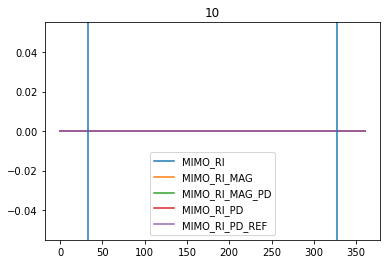

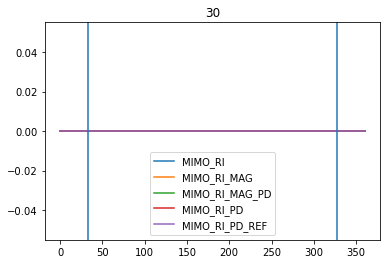

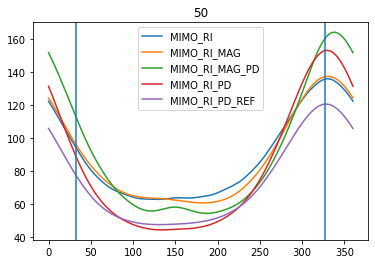

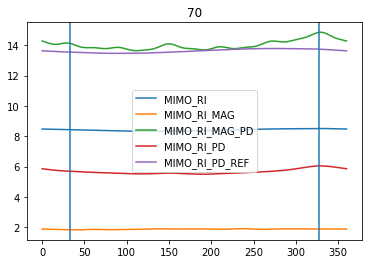

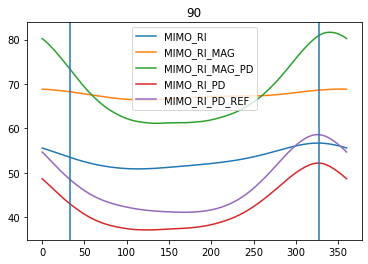

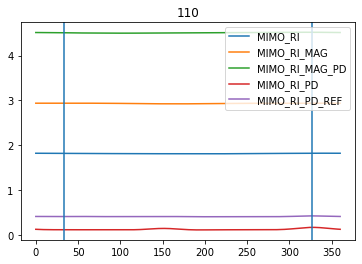

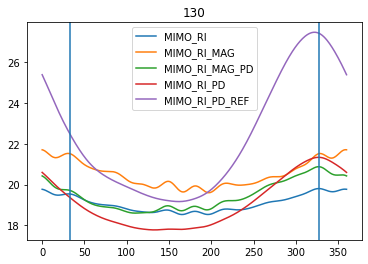

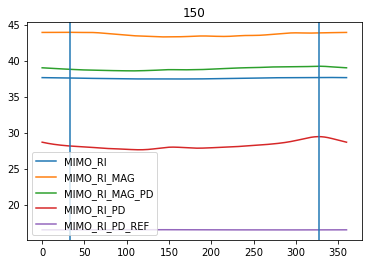

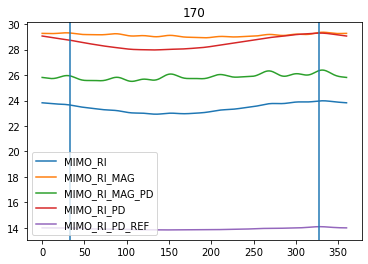

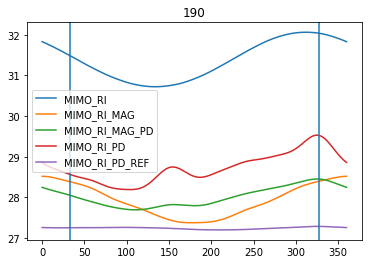

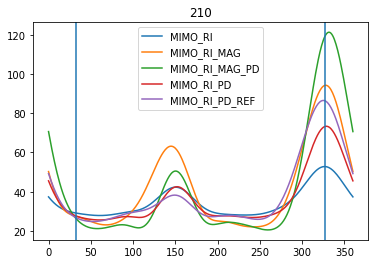

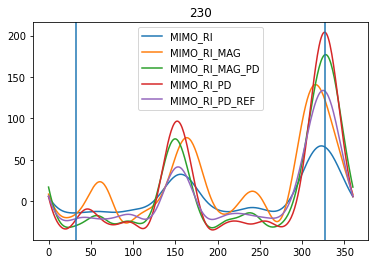

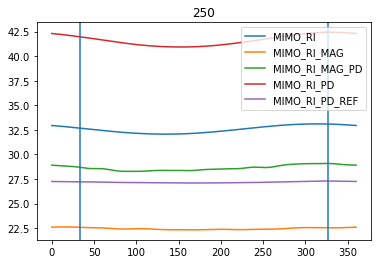

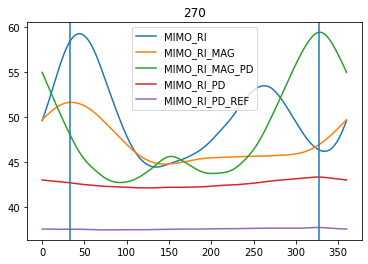

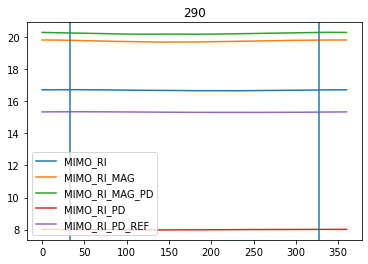

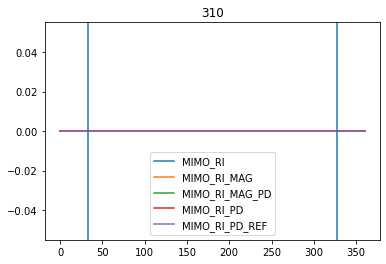

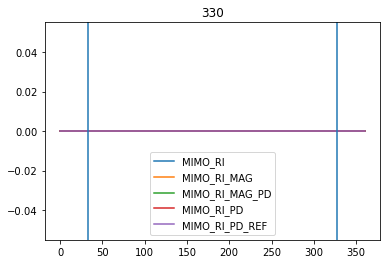

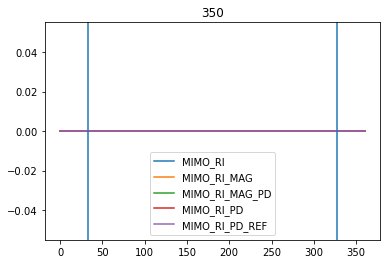

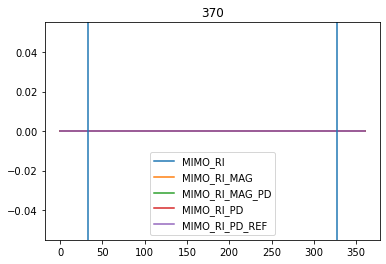

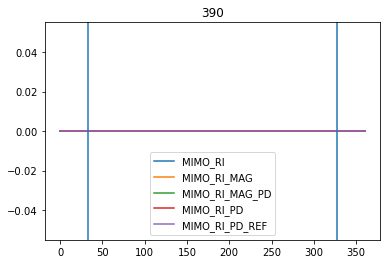

In [9]:
#circular array analysis
log_dir = '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_circular_array/noisy_reverb/diffuse/t60_1.0_snr_-5.0dB_corrected_doa_sig_norm'
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
idx = 3
all_est_dict = torch.load(os.path.join(log_dir, f'doa_1.0_{idx}_tol_5.0deg_euclid_True_wgt_mech_MASK.pt'))
for frm in range(10, 399, 20):
    plt.figure()
    for loss in loss_list:
        (est_f_doa, est_f_vals, est_utt_doa, est_frm_Acc, est_utt_Acc, metrics_list, est_mae_only_correct_frms, est_mae_only_incorrect_frms, est_mae_overall_only_vad_frms) = all_est_dict[f'{loss}']

        print(metrics_list[0]['stoi'], metrics_list[0]['pesq_nb'])
        #plt.figure()
        plt.title(f'{frm}')
        plt.plot(est_f_vals.flatten('F')[361*(frm-1):361*frm]) #column (theta)
    plt.axvline(x=est_utt_doa)
    plt.axvline(x=360-est_utt_doa)
    
    #plt.plot(est_utt_doa*torch.ones(361))
    #plt.plot(360 - est_utt_doa*torch.ones(361))
    plt.legend(loss_list)

In [5]:
metrics_list

[{'snr': 4.469100534915924,
  'si_snr': 2.550913691520691,
  'pesq_nb': 0.9929584860801697,
  'pesq_wb': 1.0519845485687256,
  'stoi': 0.6158094816113243,
  'e_stoi': 0.4270560367525186},
 {'snr': 4.259285628795624,
  'si_snr': 2.2392451763153076,
  'pesq_nb': 0.9829034805297852,
  'pesq_wb': 1.0514912605285645,
  'stoi': 0.6186873229358594,
  'e_stoi': 0.4318336189026885},
 {'snr': 4.436013996601105,
  'si_snr': 2.4978147447109222,
  'pesq_nb': 0.9911913871765137,
  'pesq_wb': 1.048750400543213,
  'stoi': 0.6144609982468969,
  'e_stoi': 0.4223600733300354},
 {'snr': 4.39330518245697,
  'si_snr': 2.4374693632125854,
  'pesq_nb': 0.9878867268562317,
  'pesq_wb': 1.050577998161316,
  'stoi': 0.6183263030857853,
  'e_stoi': 0.4298180467672454},
 {'snr': 4.430807828903198,
  'si_snr': 2.4923235177993774,
  'pesq_nb': 1.0007503032684326,
  'pesq_wb': 1.0515090227127075,
  'stoi': 0.6188933241092462,
  'e_stoi': 0.4255095754431162},
 {'snr': 4.351675510406494,
  'si_snr': 2.3717059195041656,

In [1]:
#grep "mix_8mic_mae_info" Test_functions_comparison_2m_25145942_13.out
import os
path = '/users/PAS1937/battula12/Shanmukh/Projects/MVTSS/Controlled_Experiments/Logs/8cm_array_8mic/reverb/real_rirs/Test_functions_comparison_2m_25145942_13.out'

mix_mae_ov = []
with open(path, 'r') as f:
    for line in f.readlines():
        line = line.strip()
        if "mix_8mic_mae_info" in line:
            mix_mae_ov.append(float(line.split()[-1]))

In [3]:
mix_mae_ov[-1]

'6.56598425051334'